# German Speed Limit Sign Recognition with Tensorflow and Keras

In [2]:
%matplotlib inline
%pylab inline

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [7]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [8]:
!conda install --name root scikit-learn -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B
    mkl-2017.0.1               |                0       128.2 MB
    numpy-1.11.3               |           py35_0         6.7 MB
    numexpr-2.6.2              |      np111py35_0         363 KB
    scipy-0.18.1               |      np111py35_1        31.2 MB
    scikit-learn-0.18.1        |      np111py35_1        11.1 MB
    conda-4.3.13               |           py35_0         505 KB
    ------------------------------------------------------------
                                           Total:       178.1 MB

The following packages will be UPDATED:

    conda:        4.2.13-py35_0      conda-forge --> 4.3.13-py35_0     
   

In [9]:
import sklearn
# should at least be 0.18
sklearn.__version__

'0.18.1'

In [5]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following NEW packages will be INSTALLED:

    mock:       2.0.0-py35_0  conda-forge
    pbr:        1.10.0-py35_0 conda-forge
    protobuf:   3.2.0-py35_0  conda-forge
    tensorflow: 1.0.0-py35_0  conda-forge

The following packages will be SUPERCEDED by a higher-priority channel:

    conda:      4.3.9-py35_0              --> 4.2.13-py35_0 conda-forge
    conda-env:  2.6.0-0                   --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.42 MB/s
conda-4.2.13-p 100% |################################| Time: 0:00:00   1.38 MB/s
protobuf-3.2.0 100% |################################| Time: 0:00:00  18.73 MB/s
pbr-1.10.0-py3 100% |################################| Time: 0:00:00  41.28 MB/s
mock-2.0.0-py3 100% |################################| Time: 0:00:00  43.89 MB/s
tensorflow-1

In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# should at least be 1.0
tf.__version__

'1.0.0'

In [10]:
!pip install keras

    100% |################################| 184kB 3.4MB/s ta 0:00:01
    100% |################################| 2.9MB 378kB/s eta 0:00:01
  Running setup.py bdist_wheel for keras ... - \ | done
  Stored in directory: /home/nbuser/.cache/pip/wheels/f6/c5/63/97d96b41bf822858027c70b04448c19deaccf1cf518148fa82
  Running setup.py bdist_wheel for theano ... - \ | / - \ | done
  Stored in directory: /home/nbuser/.cache/pip/wheels/96/2b/3d/71d54e24a7171a4afb7144d1e944a7be643b448b23a35b9937
Successfully built keras theano
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import keras as keras
# should at least be 1.2 and use TensorFlow backend
keras.__version__

'1.2.2'

## Download data

In [3]:
# https://notebooks.azure.com/faq#service_restrictions
# https://notebooks.azure.com/faq#upload_data
# https://notebooks.azure.com/n/xwZx1vmIroU/notebooks/Getting%20to%20your%20Data%20in%20Azure%20Notebooks.ipynb

In [13]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  3430k      0 --:--:-- --:--:-- --:--:-- 3434k


In [14]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

In [15]:
!ls -l speed-limit-signs

total 28
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 0
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 1
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 2
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 3
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 4
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 5
-rw-r--r-- 1 nbuser nbuser  380 Feb 26 08:21 README.md


## Analyse and Prepare Image Data

### Kudos to https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib for providing my with the initial idea and many of the functions used to prepare and display the images

In [16]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [18]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [19]:
len(set(labels)), len(images)

(6, 379)

In [20]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

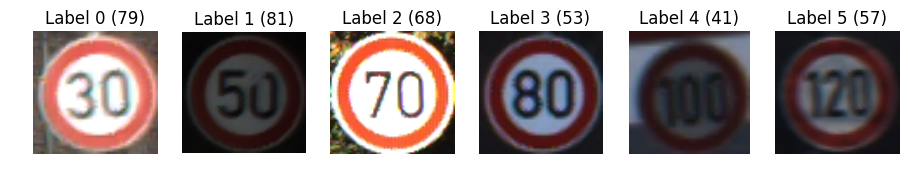

In [21]:
display_images_and_labels(images, labels)

In [22]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (50, 50, 3), min: 11, max: 139
shape: (33, 33, 3), min: 6, max: 98
shape: (20, 22, 3), min: 24, max: 179
shape: (49, 49, 3), min: 7, max: 189
shape: (41, 41, 3), min: 8, max: 86


In [23]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [24]:
for image in images64[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (64, 64, 3), min: 0.045677274816176325, max: 0.5281192555147057
shape: (64, 64, 3), min: 0.040650371476715595, max: 0.37439084520526966
shape: (64, 64, 3), min: 0.09411764705882353, max: 0.6777516084558827
shape: (64, 64, 3), min: 0.03952612783394603, max: 0.7256433823529411
shape: (64, 64, 3), min: 0.03137254901960784, max: 0.32432909198835824


In [25]:
y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))